#### 1) Загрузите данные ex3data1.mat из файла.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = '/home/ataleckij/Projects/university/mo/Data/Lab 3/'

In [3]:
files_names = os.listdir(DATA_PATH)
print(files_names)
files_paths = [os.path.join(DATA_PATH, name) for name in files_names]

['ex3data1.mat']


In [4]:
from scipy.io import loadmat

data = loadmat(files_paths[0])

X, y = data['X'], data['y'].flatten()
print(X.shape, y.shape)

Xval, yval = data['Xval'], data['yval'].flatten()
print(Xval.shape, yval.shape)

Xtest, ytest = data['Xval'], data['yval'].flatten()
print(Xtest.shape, ytest.shape)

(12, 1) (12,)
(21, 1) (21,)
(21, 1) (21,)


#### 2) Постройте график, где по осям откладываются X и y из обучающей выборки.

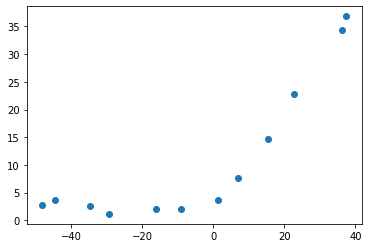

In [5]:
plt.scatter(X.flatten(), y)

#### 3) Реализуйте функцию стоимости потерь для линейной регрессии с L2-регуляризацией.

In [6]:
@np.vectorize
def hack_log(x):
    return np.log(x) if x != 0 else 0

def loss_l2(y_pred, y_true, w, lambda_):
    y_pred, y_true, w = np.array(y_pred), np.array(y_true), np.array(w)
    m = y_pred.shape[0]
    l2_value = lambda_ * w.dot(w) / 2
    return 1/(2*m) * ((y_pred - y_true) ** 2).sum() + l2_value

#### 4) Реализуйте функцию градиентного спуска для линейной регрессии с L2-регуляризацией.

In [7]:
class LinearRegressionL2:
    def __init__(self, w=None, lr=0.01, lambda_=0.001):
        self.w = np.array(w) if not (isinstance(w, np.ndarray) or w is None) else w
        self.lr = lr
        self.history = []
        self.lambda_ = lambda_
        assert self.lr * self.lambda_ < 1
    
    def _calc_grad(self, prediction, labels, data_with_offset):
        return ((prediction - labels) * data_with_offset.T).T.mean(axis=0)
    
    def _log_history(self, iterarion, prediction, labels, grad):
        loss_value = loss_l2(prediction, labels, w=self.w, lambda_=self.lambda_)
        self.history.append((iterarion, loss_value, grad))
    
    def fit(self, data, labels, max_iters=None, optimizer='grad', verbosity=False):
        data, labels = np.array(data), np.array(labels)
        
        if self.w is None:
            self.w = np.zeros(data.shape[1] + 1)
        else:
            assert self.w.shape[0] == (data.shape[1] + 1)
        
        data_with_offset = np.hstack((np.ones((data.shape[0], 1)), data))
        prediction = self.predict(data_with_offset)
        if verbosity:
            print(loss_l2(prediction, labels, w=self.w, lambda_=self.lambda_))
        
        if optimizer == 'grad':
            grad = self._calc_grad(prediction, labels, data_with_offset)
            l2_part_value = self.lambda_ * self.w
            iterarion = 0
            self._log_history(iterarion, prediction, labels, grad)
            while not np.allclose(self.lr * (grad + l2_part_value), np.zeros(grad.shape)):
                l2_part_value = self.lambda_ * self.w
                self.w -= self.lr * (grad + l2_part_value)
                prediction = self.predict(data_with_offset)
                grad = self._calc_grad(prediction, labels, data_with_offset)
                iterarion += 1
                self._log_history(iterarion, prediction, labels, grad)
                if verbosity:
                    print(self.history[-1][:2])
                if max_iters and max_iters <= iterarion:
                    break
        if verbosity:
            print(loss_l2(prediction, labels, w=self.w, lambda_=self.lambda_))
        
    
    def predict(self, data):
        data = np.array(data)
        if self.w.shape[0] == data.shape[1]:
            data_with_offset = data
        else:
            data_with_offset = np.hstack((np.ones((data.shape[0], 1)), data))
        return data_with_offset.dot(self.w)
    
    def evaluate(self, data, labels):
        prediction = self.predict(data)
        return loss_l2(y_pred=prediction, y_true=labels, w=self.w, lambda_=self.lambda_)

#### 5) Постройте модель линейной регрессии с коэффициентом регуляризации 0 и постройте график полученной функции совместно с графиком из пункта 2. Почему регуляризация в данном случае не сработает?

In [8]:
lreg_l2 = LinearRegressionL2(lr=0.001, lambda_=0)
lreg_l2.fit(X, y)

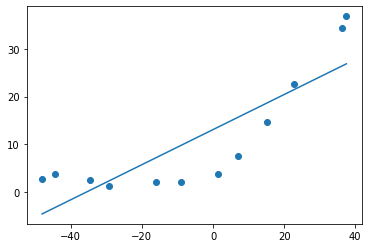

In [9]:
plt.scatter(X.flatten(), y)
x = np.linspace(X.min(), X.max(), 100).reshape((-1, 1))
plt.plot(x, lreg_l2.predict(x).flatten())
plt.show()

#### 6) Постройте график процесса обучения (learning curves) для обучающей и валидационной выборки. По оси абсцисс откладывается число элементов из обучающей выборки, а по оси ординат - ошибка (значение функции потерь) для обучающей выборки (первая кривая) и валидационной выборки (вторая кривая). Какой вывод можно сделать по построенному графику?

In [10]:
lreg_l2_val = LinearRegressionL2(lr=0.001, lambda_=0)
lreg_l2_val.fit(Xval, yval)

In [11]:
def plot_learning_curve(model, samples_per_iter, label):
    history = np.array(model.history)
    iterations, losses = history[:, 0], history[:, 1]
    return plt.plot(iterations * samples_per_iter, losses, label=label)

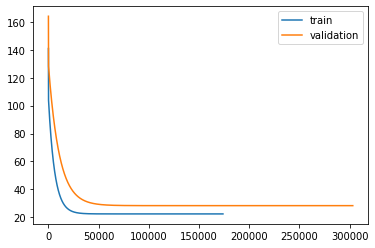

In [12]:
plot_learning_curve(lreg_l2, X.shape[0], label='train')
plot_learning_curve(lreg_l2_val, Xval.shape[0], label='validation')
plt.legend()
plt.show()

#### 7) Реализуйте функцию добавления p - 1 новых признаков в обучающую выборку (X2, X3, X4, …, Xp).

In [13]:
def generate_polinome_features(X, degree):
    Xres = []
    for cur_degree in range(1, degree + 1):
        Xres.append(X.flatten() ** cur_degree)
    return np.vstack(Xres).T

#### 8) Поскольку в данной задаче будет использован полином высокой степени, то необходимо перед обучением произвести нормализацию признаков.

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
Xp = generate_polinome_features(X, degree=8)
sc = StandardScaler()
Xp_norm = sc.fit_transform(Xp)

Xp_val = generate_polinome_features(Xval, degree=8)
Xp_val_norm = sc.transform(Xp_val)

#### 9) Обучите модель с коэффициентом регуляризации 0 и p = 8.

In [16]:
lreg_l2 = LinearRegressionL2(lr=0.1, lambda_=0)
lreg_l2.fit(Xp_norm, y, max_iters=100_000)

#### 10) Постройте график модели, совмещенный с обучающей выборкой, а также график процесса обучения. Какой вывод можно сделать в данном случае?

In [17]:
def plot_model(model, X, y, scaler):
    plt.scatter(X, y)
    x = np.linspace(X.min(), X.max(), 100).reshape((-1, 1))
    xp = generate_polinome_features(x, degree=8)
    xp_norm = scaler.transform(xp)
    return plt.plot(x, model.predict(xp_norm))

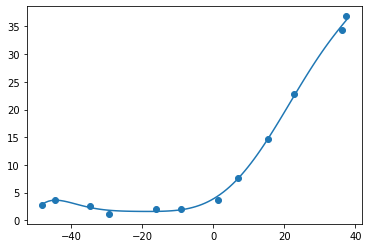

In [18]:
plot_model(lreg_l2, X, y, sc)
plt.show()

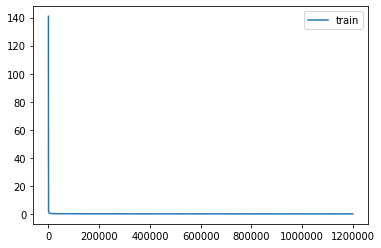

In [19]:
plot_learning_curve(lreg_l2, X.shape[0], label='train')
plt.legend()
plt.show()

#### 11) Постройте графики из пункта 10 для моделей с коэффициентами регуляризации 1 и 100. Какие выводы можно сделать?

In [20]:
C = 1 
lambda_ = 1/C
lreg_l2 = LinearRegressionL2(lr=0.1, lambda_=lambda_)
lreg_l2.fit(Xp_norm, y, max_iters=100_000)

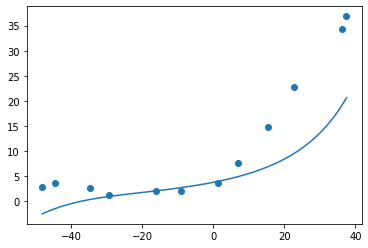

In [21]:
plot_model(lreg_l2, X, y, sc)
plt.show()

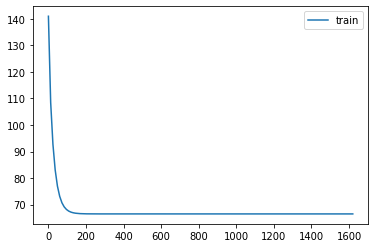

In [22]:
plot_learning_curve(lreg_l2, X.shape[0], label='train')
plt.legend()
plt.show()

In [23]:
C = 100 
lambda_ = 1/C
lreg_l2 = LinearRegressionL2(lr=0.005, lambda_=lambda_)
lreg_l2.fit(Xp_norm, y, max_iters=100_000)

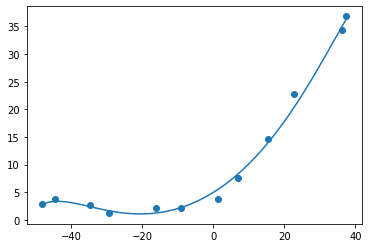

In [24]:
plot_model(lreg_l2, X, y, sc)
plt.show()

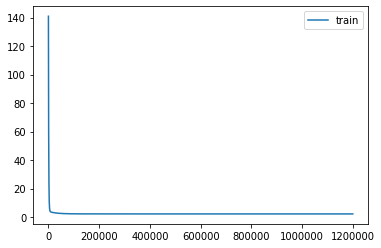

In [25]:
plot_learning_curve(lreg_l2, X.shape[0], label='train')
plt.legend()
plt.show()

#### 12) С помощью валидационной выборки подберите коэффиент регуляризации, который позволяет достичь наименьшей ошибки. Процесс подбора отразите с помощью графика (графиков).

In [26]:
from tqdm import tqdm

C_values = [10, 25, 50, 75, 100, 250, 500, 750, 1000]
train_losses, val_losses = [], []

for C in tqdm(C_values):
    lambda_ = 1/C
    lreg_l2 = LinearRegressionL2(lr=0.005, lambda_=lambda_)
    lreg_l2.fit(Xp_norm, y, max_iters=50_000)
    train_losses.append(lreg_l2.history[-1][1])
    val_loss = lreg_l2.evaluate(Xp_val_norm, yval)
    val_losses.append(val_loss)

100%|██████████| 9/9 [00:38<00:00,  4.28s/it]


[]

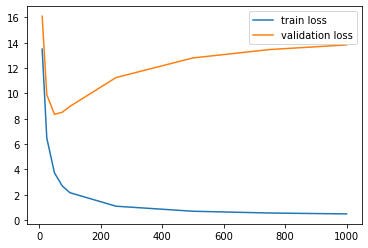

In [27]:
plt.plot(C_values, train_losses, label='train loss')
plt.plot(C_values, val_losses, label='validation loss')
plt.legend()
plt.plot()

In [28]:
val_losses

[16.096508661804883,
 9.898635315188631,
 8.349258928419182,
 8.511242498530521,
 8.972837387046233,
 11.252286297048677,
 12.803149220148374,
 13.46673948323574,
 13.832124834551934]

#### 13) Вычислите ошибку (потерю) на контрольной выборке.

In [32]:
C_best = 50
lambda_best = 1/C_best

Xp_work_norm = np.concatenate((Xp_norm, Xp_val_norm))
y_work = np.concatenate((y, yval))

lreg_l2 = LinearRegressionL2(lr=0.005, lambda_=lambda_best)
lreg_l2.fit(Xp_work_norm, y_work, max_iters=100_000)

Xp_test = generate_polinome_features(Xtest, degree=8)
Xp_test_norm = sc.transform(Xp_test)
test_loss = lreg_l2.evaluate(Xp_test_norm, ytest)

In [33]:
test_loss

5.586436750003026

In [34]:
Xp_test_norm.shape, ytest.shape

((21, 8), (21,))

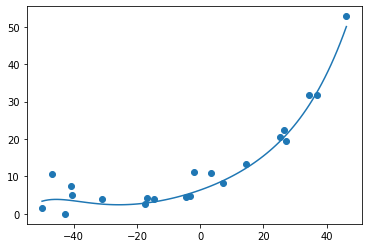

In [35]:
plot_model(lreg_l2, Xtest, ytest, sc1)
plt.show()

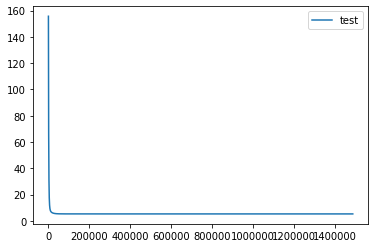

In [36]:
plot_learning_curve(lreg_l2, Xtest.shape[0], label='test')
plt.legend()
plt.show()